In [3]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [4]:
from common import *
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [5]:
np.random.seed(0)

In [6]:
import warnings; warnings.simplefilter('ignore')

In [7]:
# Dataset Phone Price
x_train, x_test, y_train, y_test = read_dataset(path_to_file="../Data/dataset2/train.csv")

In [8]:
y_test[y_test<=1] = 0
y_test[y_test>=2] = 1
y_train[y_train<=1] = 0
y_train[y_train>=2] = 1

In [9]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = MinMaxScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')

In [17]:
rc_errors = {}
for i in range(2, 50):
    ica = FastICA(n_components=i, random_state=0)
    x_prime = ica.fit_transform(x_train_scaled)
    
    # reconstruction
    A = np.linalg.pinv(ica.components_.T)
    reconstructed = np.dot(x_prime, A)
    rc_err = mean_squared_error(x_train_scaled, reconstructed)    
    rc_errors[i] = rc_err

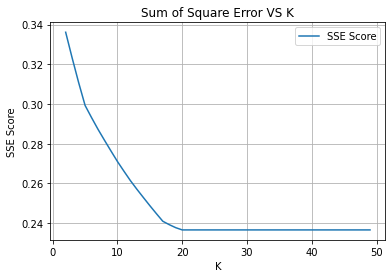

In [18]:
plt.figure()
plt.plot(list(rc_errors.keys()), list(rc_errors.values()), label="SSE Score")
plt.title(f"Sum of Square Error VS K")
plt.xlabel("K")
plt.ylabel("SSE Score")
plt.grid()
plt.legend()
plt.show()

In [28]:
comp = 20
ica = FastICA(n_components=comp, random_state=0, max_iter=1000)
ica_result = ica.fit_transform(x_train_scaled)
for i in range(0, comp):
    x_train[f"ica-{i}"] = ica_result[:,i]

<AxesSubplot:xlabel='ica-0', ylabel='ica-1'>

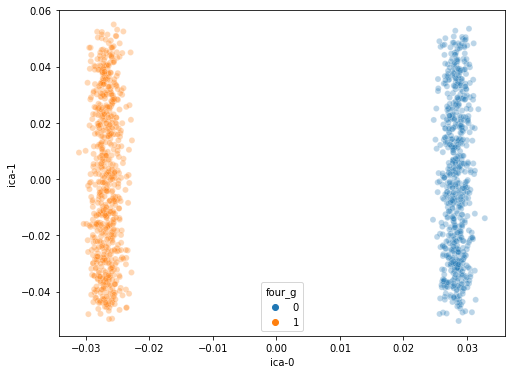

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="ica-0", y="ica-1",
    hue="four_g",
    data=x_train,
    legend="full",
    alpha=0.3
)

In [32]:
x_train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,ica-10,ica-11,ica-12,ica-13,ica-14,ica-15,ica-16,ica-17,ica-18,ica-19
1520,1883,0,1.6,0,9,0,24,0.1,87,1,...,-0.029958,0.029763,-0.017002,-0.043119,-0.040829,0.027938,0.032000,-0.003505,0.041267,0.026245
64,702,0,2.6,1,2,1,9,0.7,141,3,...,-0.014530,-0.013860,0.020206,0.001609,0.044182,-0.028182,0.024566,-0.035939,-0.006669,0.026954
1431,1283,1,0.7,1,0,1,27,0.2,80,4,...,0.012754,0.029940,0.045596,-0.044734,-0.025983,-0.025790,0.041907,0.024769,-0.005542,-0.026680
926,1496,1,1.9,1,13,0,38,0.1,126,4,...,0.006948,0.028537,-0.048841,-0.007461,-0.022887,-0.025685,-0.008746,-0.014723,0.047761,-0.027083
983,1175,1,1.3,0,2,0,19,0.3,164,7,...,0.018338,-0.019790,0.009056,0.017179,-0.013438,0.028402,-0.003982,0.011824,-0.038822,-0.028324


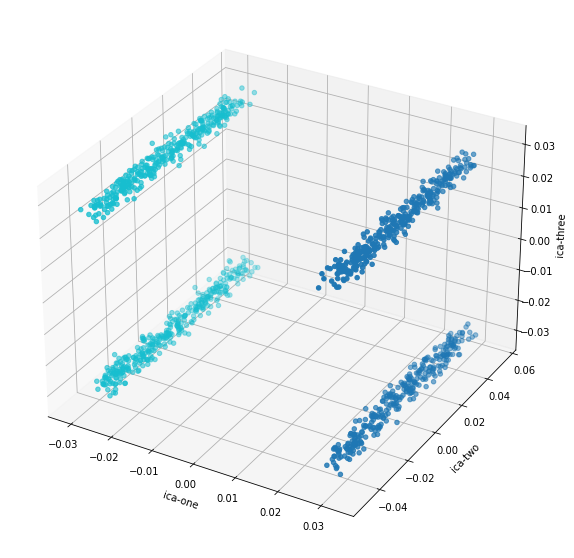

In [45]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=x_train["ica-0"], 
    ys=x_train["ica-1"], 
    zs=x_train["ica-2"], 
    c=x_train["four_g"], 
    cmap='tab10'
)
ax.set_xlabel('ica-one')
ax.set_ylabel('ica-two')
ax.set_zlabel('ica-three')
plt.show()

In [55]:
s = {}
h = {}
clusters = range(2, 25)
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-1).fit(ica_result)
    label = kmeans.labels_
    s[cluster] = silhouette_score(ica_result, label, metric='euclidean')
    h[cluster] = homogeneity_score(y_train['price_range'].values, label)

In [58]:
sdf = pd.DataFrame(list(s.values()), columns=['Silhouette'])
sdf['Homogeneity'] = pd.DataFrame(list(h.values()))

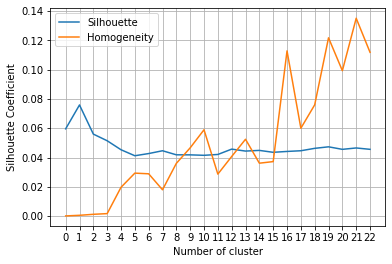

In [65]:
plt.figure()
plt.plot(sdf)
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.legend(sdf.columns)
plt.xticks(range(sdf.shape[0]))
plt.show()

In [66]:
s_EM = {}
h_EM = {}
log_likelihood_EM = {}
clusters = range(2, 25)
for cluster in clusters:
    print(cluster)
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=0, n_init=50).fit(ica_result)
    label = gmm.predict(ica_result)
    s_EM[cluster] = silhouette_score(ica_result, label, metric='euclidean')
    h_EM[cluster] = homogeneity_score(y_train['price_range'].values, label)
    log_likelihood_EM[cluster] = gmm.score(ica_result)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [69]:
gdf = pd.DataFrame(list(s.values()), columns=['Silhouette'])
gdf['Homogeneity'] = pd.DataFrame(list(h.values()))
gdf['Likelihood'] = pd.DataFrame(list(log_likelihood_EM.values()))

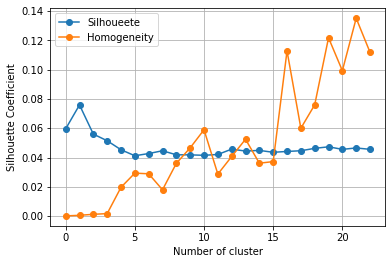

In [77]:
plt.figure()
plt.plot(gdf[['Silhouette', 'Homogeneity']], 'o-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.grid()
plt.legend(['Silhoueete', 'Homogeneity'])
plt.show()

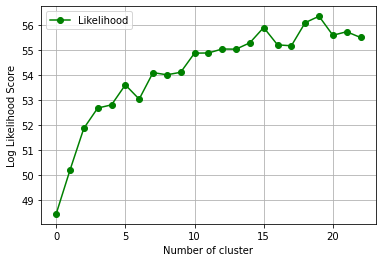

In [80]:
plt.figure()
plt.plot(gdf[['Likelihood']], 'o-', color="green")
plt.xlabel("Number of cluster")
plt.ylabel("Log Likelihood Score")
plt.grid()
plt.legend(['Likelihood'])
plt.show()